# Including a starting model
Here we will expand the `simple_inversion.ipynb` example by showing how to incorporate a non-flat starting model. A typical scenario for where this is useful is if you have a few point measurements of the elevations of the surface you are aiming to recover. These point measurements, referred to here as `constraints`, may be boreholes, acoustic basement from seismic surveys, or other types of measurements.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This simulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point within the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

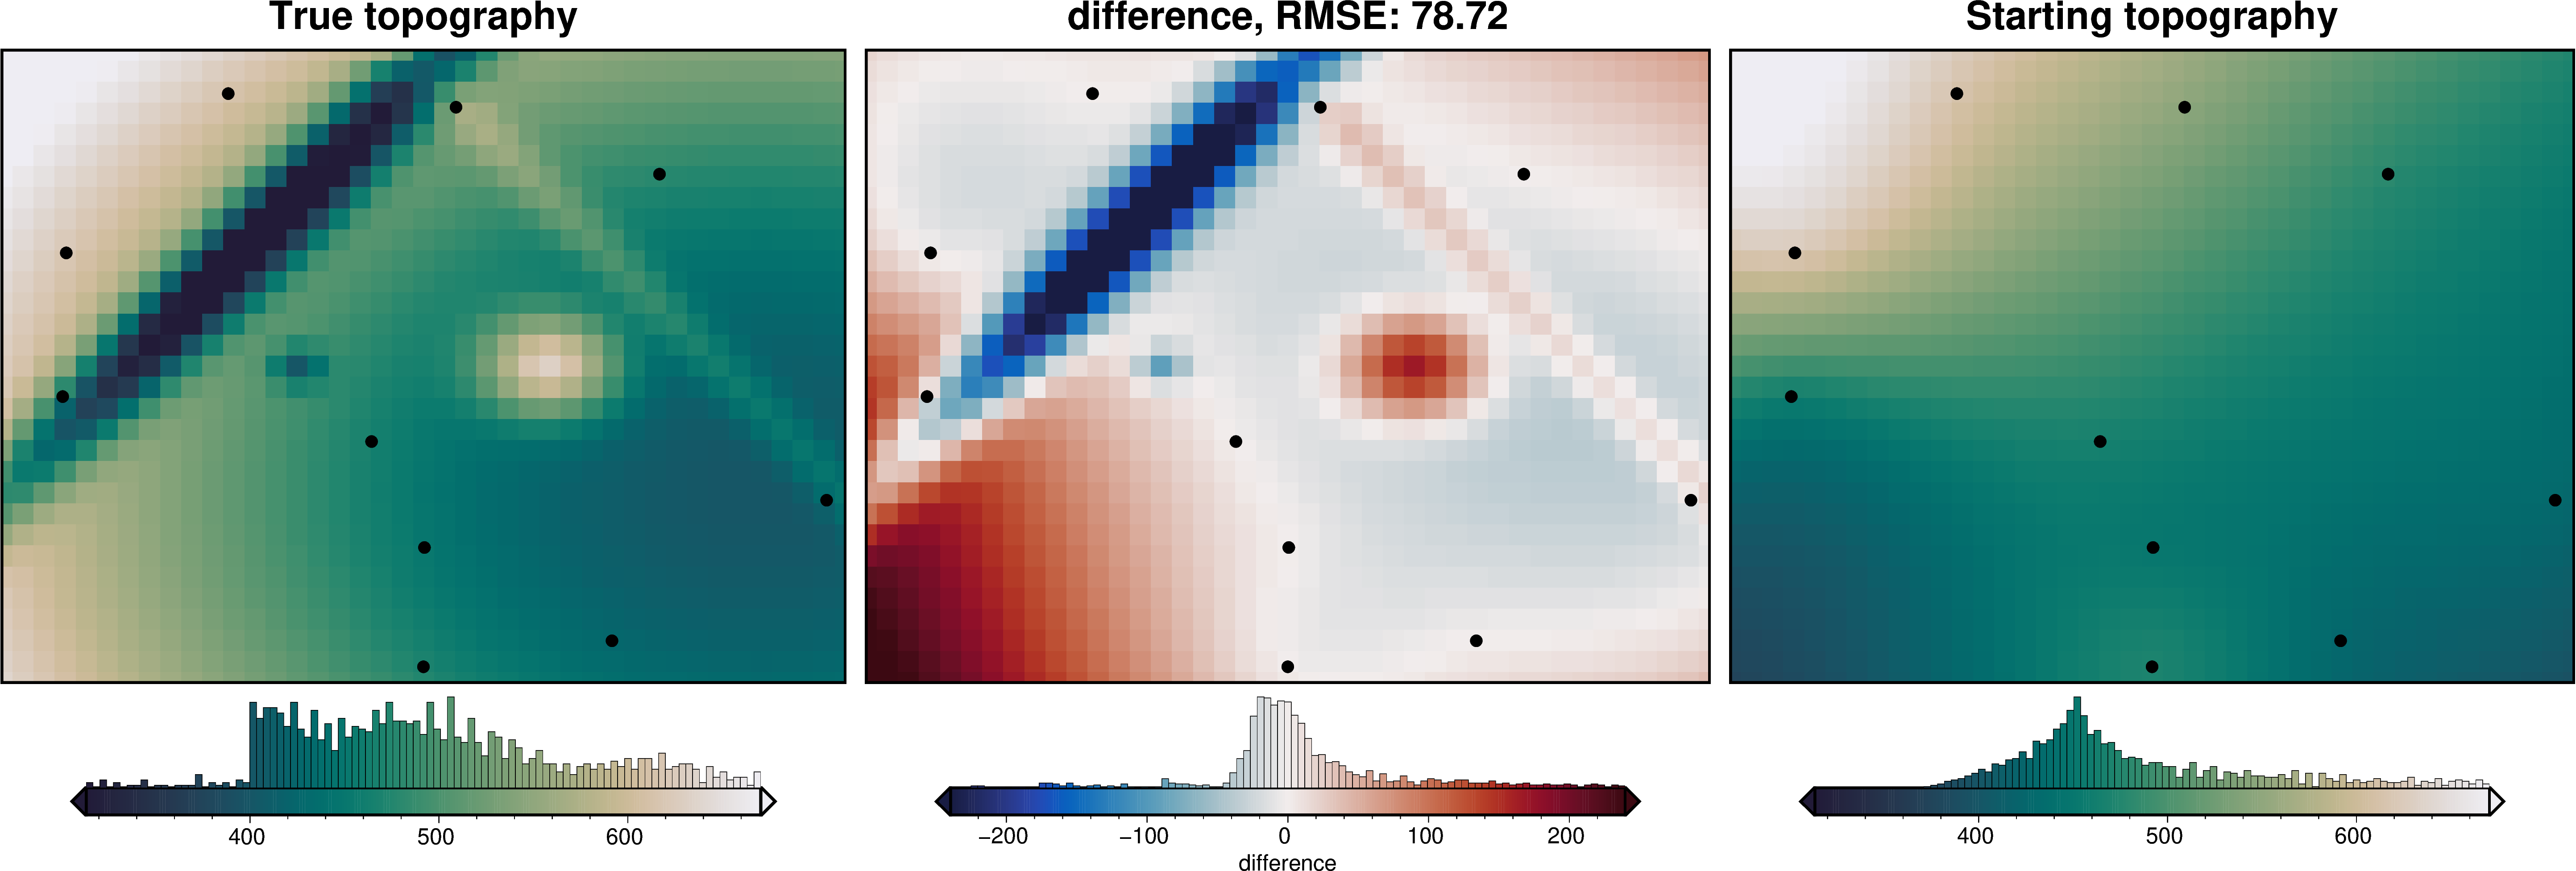

In [4]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [14]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


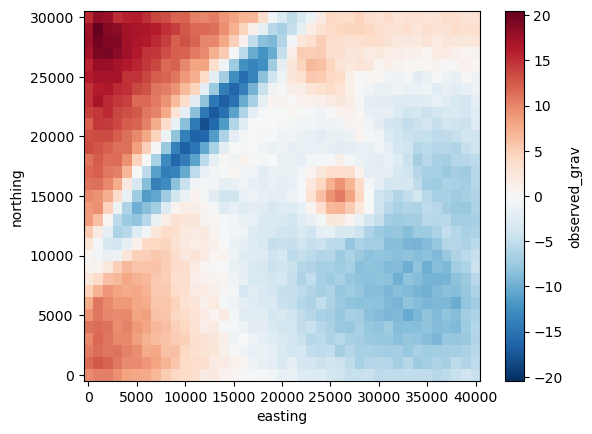

In [7]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

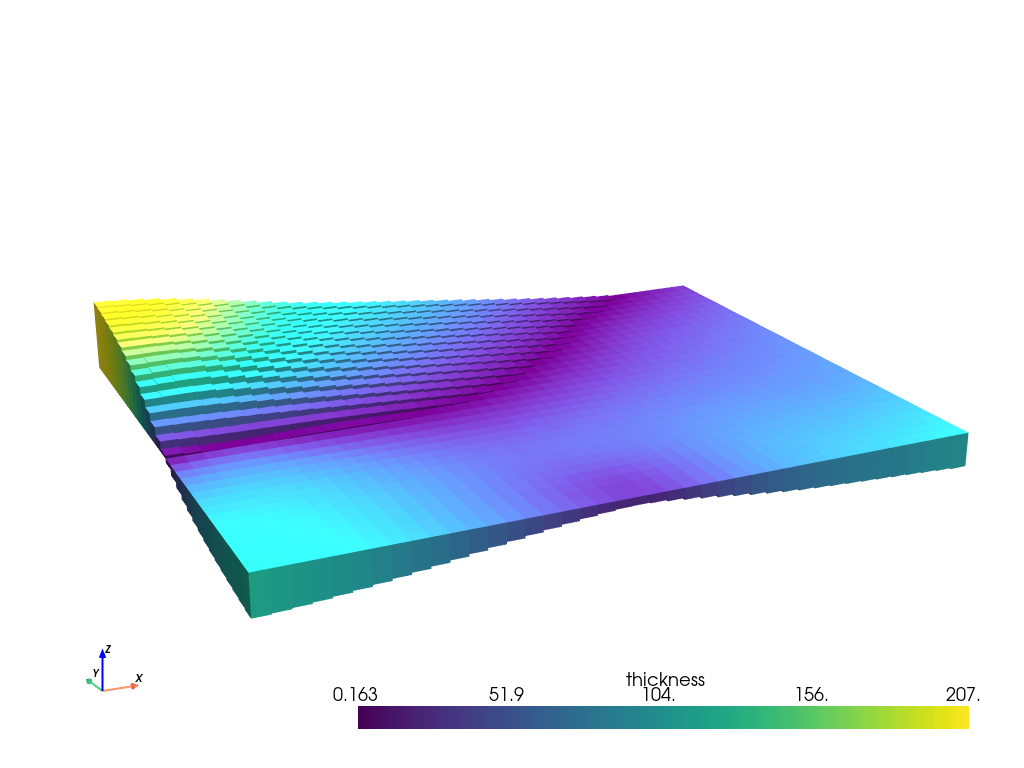

In [16]:
# keep the reference level set to the mean of the true topography grid

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [17]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,9.617711,-6.928812,16.546523,0,16.546523
1,0.0,1000.0,1000.0,10.422834,10.376985,-8.207987,18.584972,0,18.584972
2,0.0,2000.0,1000.0,9.949973,10.290387,-8.333770,18.624158,0,18.624158
3,0.0,3000.0,1000.0,9.269279,9.341932,-8.213033,17.554965,0,17.554965
4,0.0,4000.0,1000.0,8.532160,8.284528,-7.985477,16.270005,0,16.270005
...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,2.794223,-0.512233,3.306456,0,3.306456
1267,30000.0,37000.0,1000.0,3.330307,3.683446,-0.787084,4.470530,0,4.470530
1268,30000.0,38000.0,1000.0,3.335438,3.501867,-1.039166,4.541033,0,4.541033
1269,30000.0,39000.0,1000.0,3.300721,2.848068,-1.241752,4.089819,0,4.089819


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0


Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -5.068 m, RMSE:33.278 m
INFO:root:updated misfit RMSE: 4.0344
INFO:root:updated L2-norm: 2.0086, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.3261, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: -0.0562 m, RMSE:18.5996 m
INFO:root:updated misfit RMSE: 2.3911
INFO:root:updated L2-norm: 1.5463, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2989, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 1.7289 m, RMSE:10.6413 m
INFO:root:updated misfit RMSE: 1.5079
INFO:root:updated L2-norm: 1.228, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2592, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 1.4589 m, RMSE:6.3535 m
INFO:root:updated misfit RMSE: 1.0258
INFO:root:updated L2-norm: 1.01

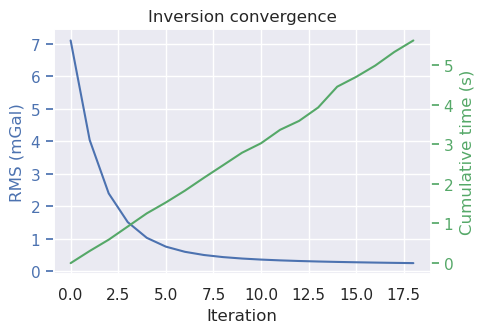

In [18]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

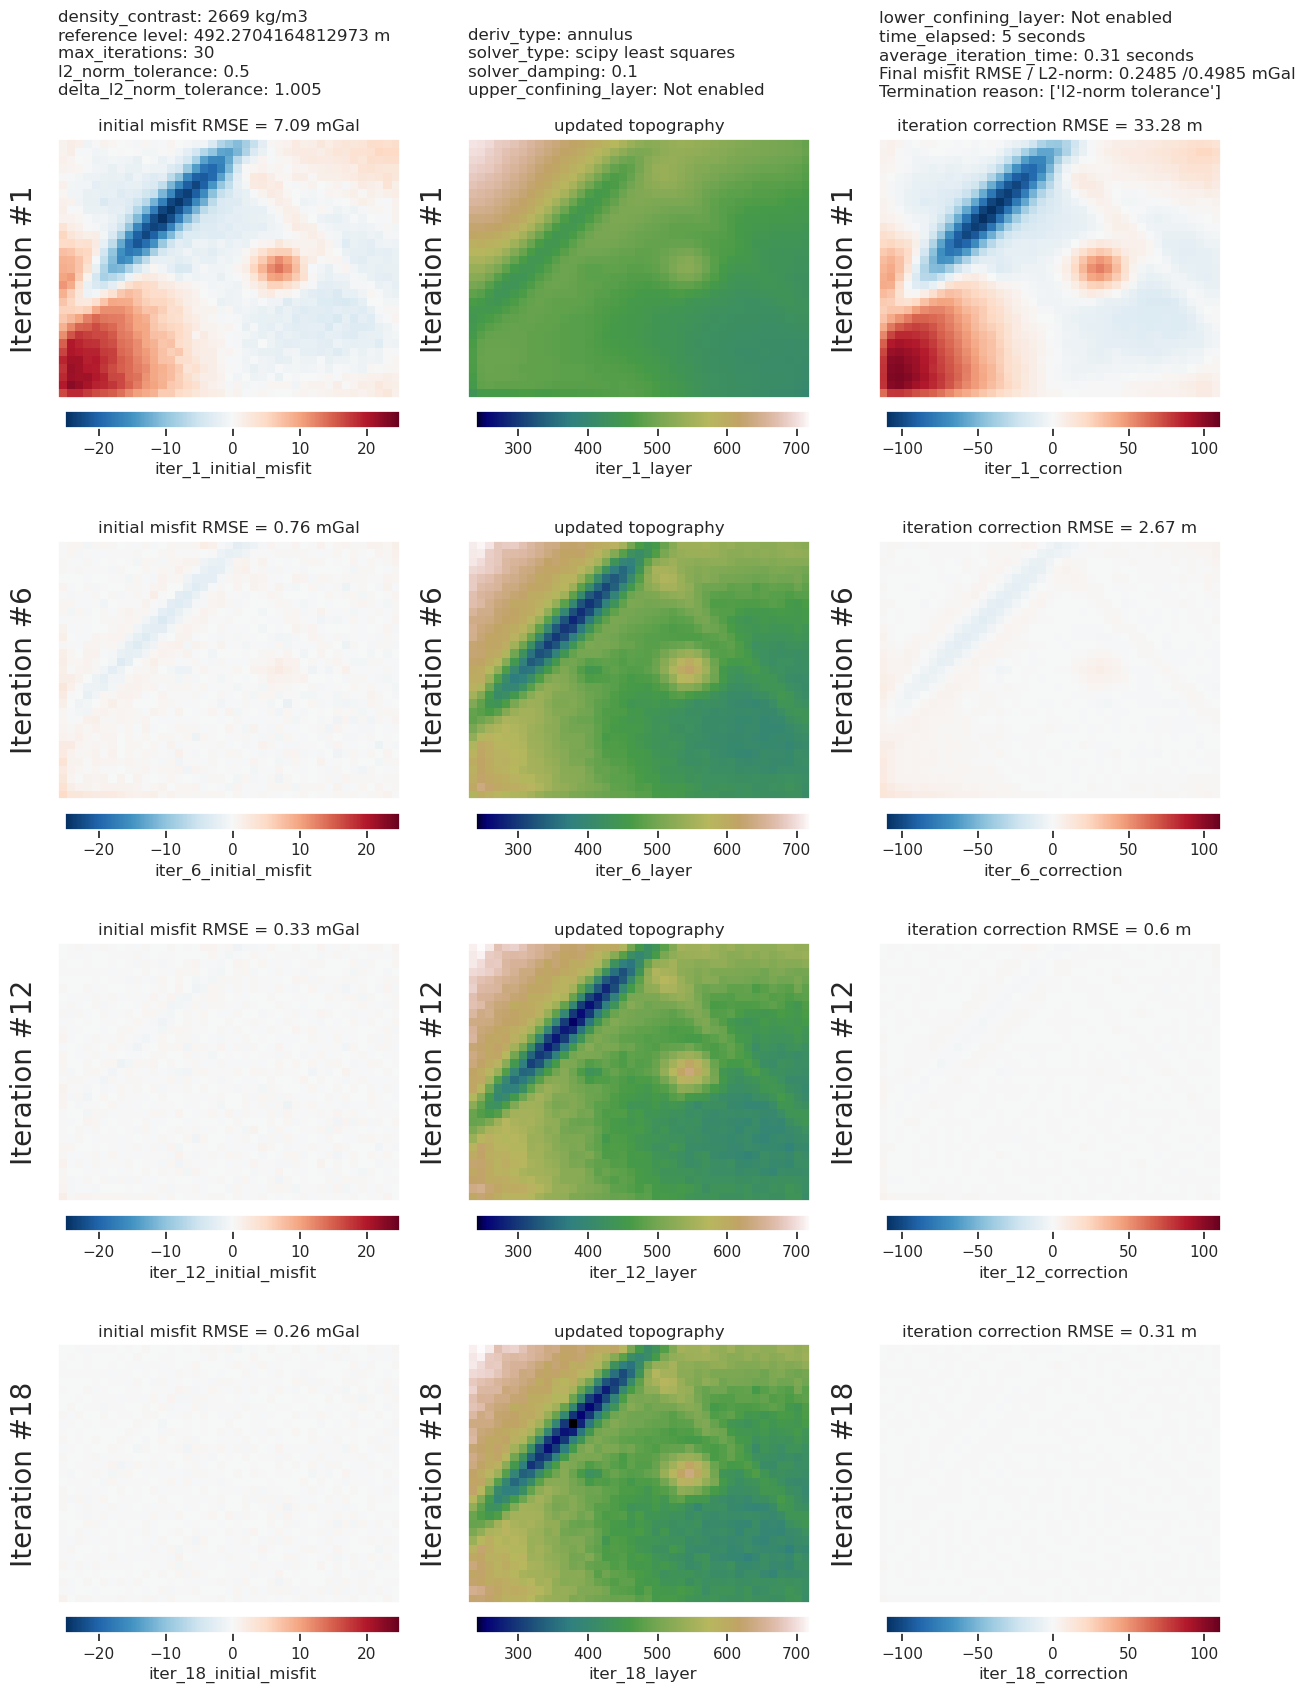

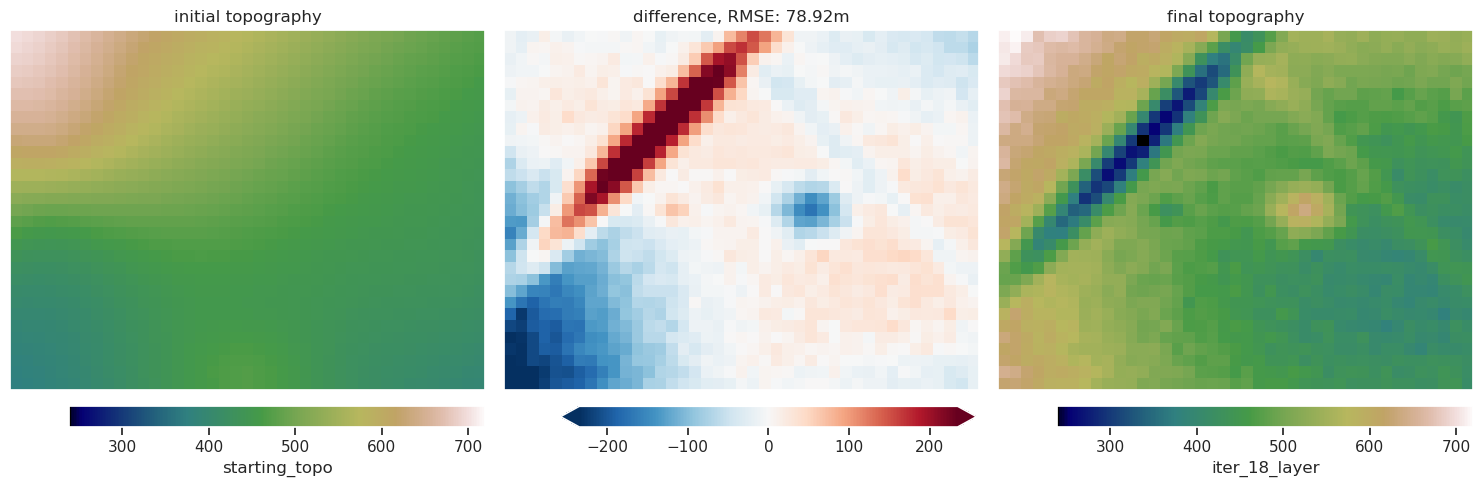

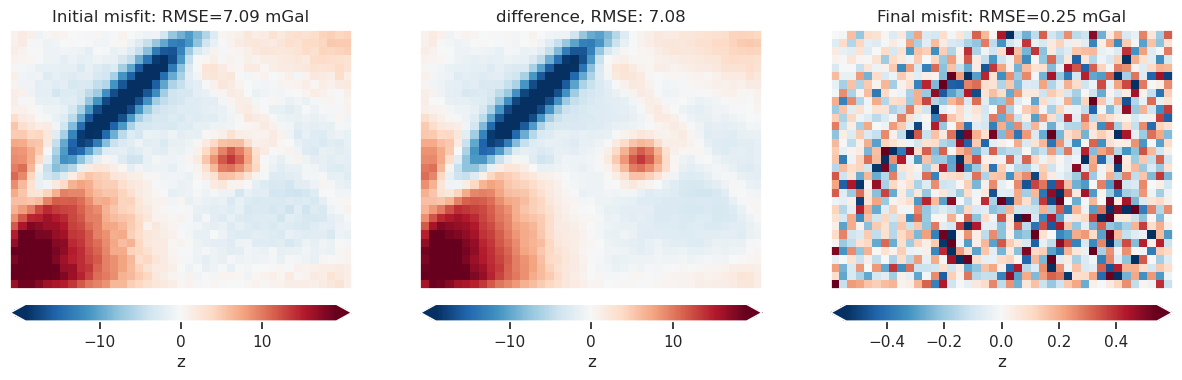

In [19]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

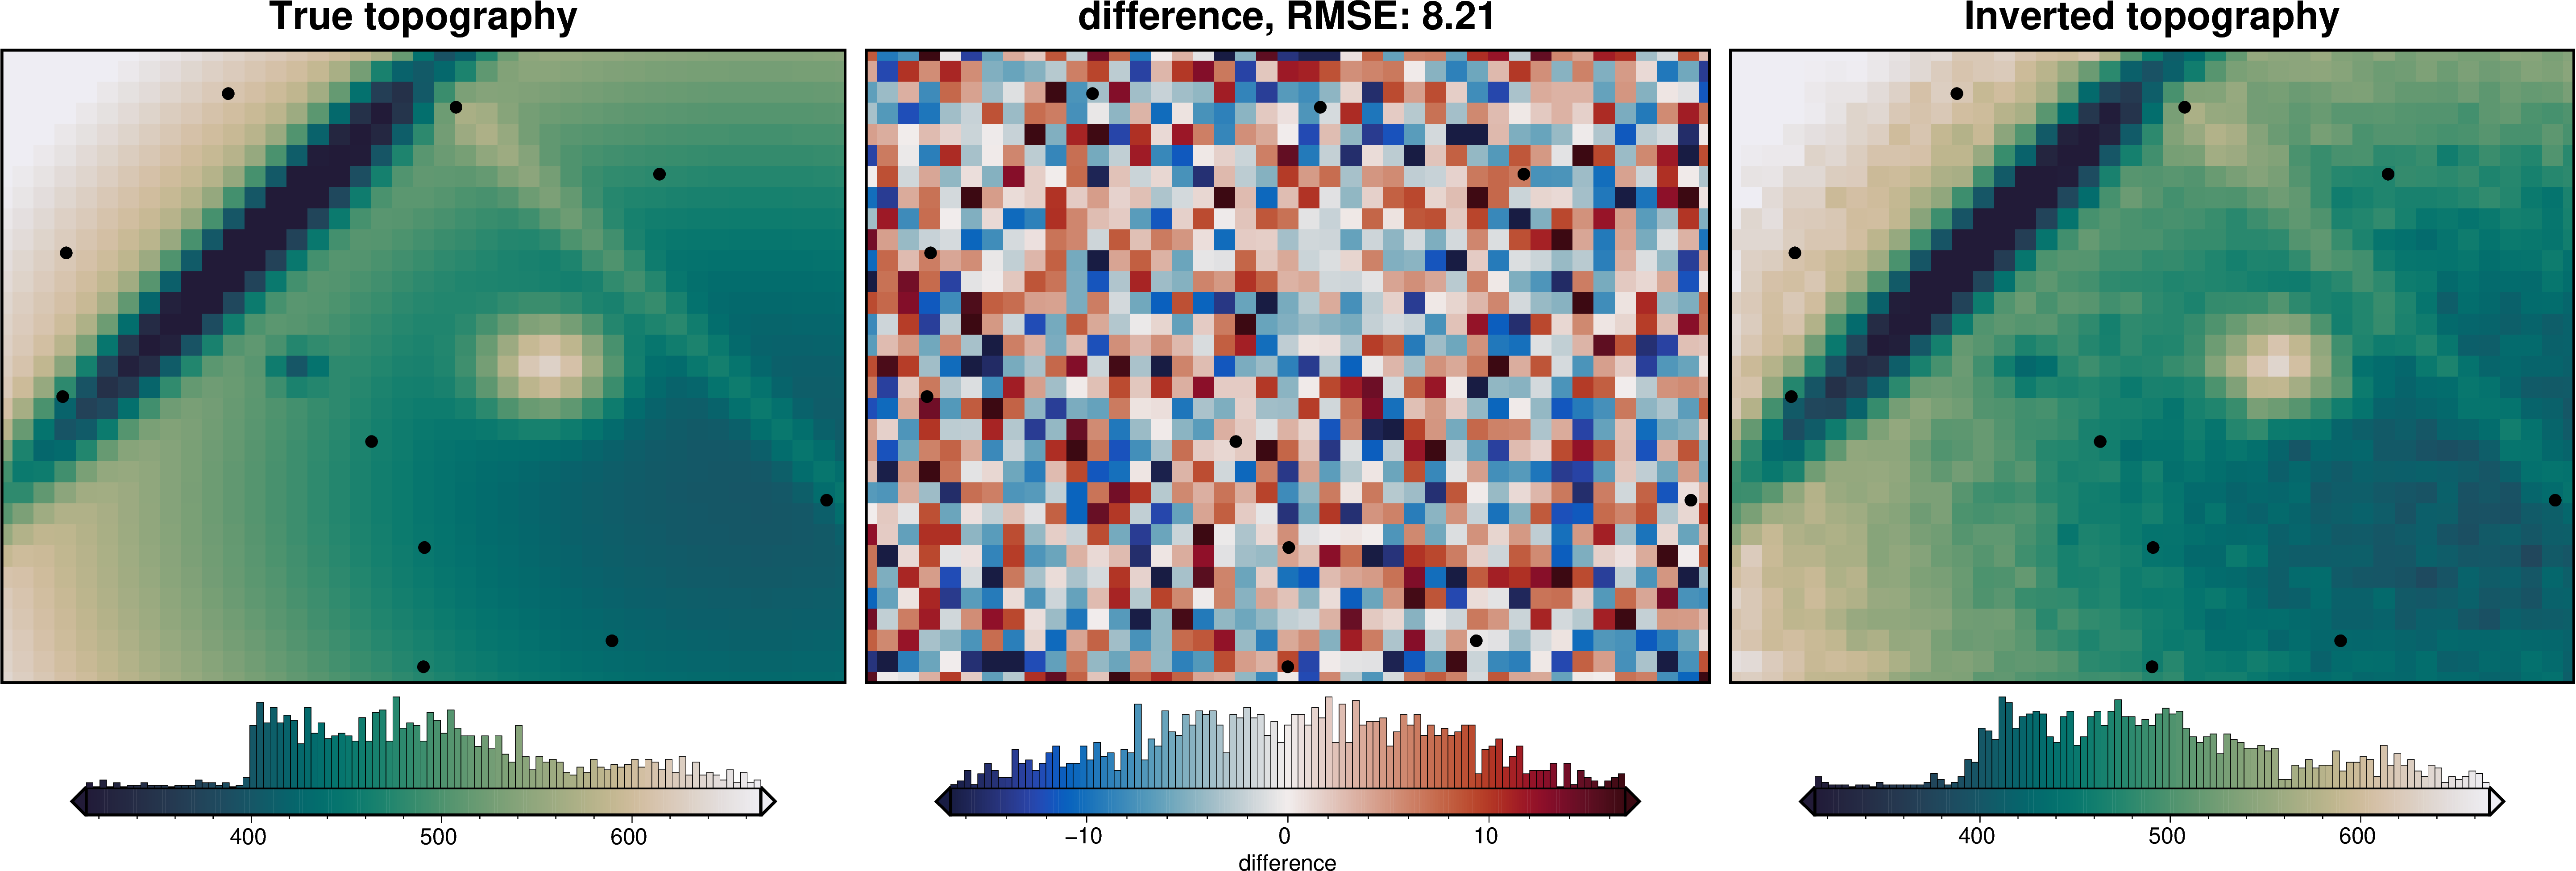

In [20]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

In [21]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 5.89 m


The RMSE between the constraint's true values and the inverted topography at the constraint's is not 0. This shows that while the starting model helped the inversion, the actual values of the constraints is not adhered too. The next inversion (`adhering_to_constraints.ipynb`) will show how to help the model stick to the constraints. 